In [4]:
# === Colab Cell 1: Setup & Imports ===
!pip -q install plotly==5.22.0
import os, io, requests, zipfile, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import joblib
# For Colab Drive
from google.colab import drive
drive.mount('/content/drive')
# Where to save model & artifacts
BASE_DIR = "/content/drive/MyDrive/exoplanet_mvp"
os.makedirs(BASE_DIR, exist_ok=True)
MODEL_PATH = os.path.join(BASE_DIR, "rf_koi_model.pkl")
NEW_OBS_CSV = os.path.join(BASE_DIR, "new_observations.csv")

Mounted at /content/drive


In [5]:
# === Colab Cell 2: Load KOI data ===
# Option A: Auto-download directly from NASA Exoplanet Archive (CSV via TAP)
KOI_URL = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select%20*%20from%20q1_q17_dr25_koi&format=csv"
try:
    koi_df = pd.read_csv(KOI_URL)
    print("Loaded KOI from NASA:", koi_df.shape)
except Exception as e:
    print("Auto-download failed:", e)
    print("Fallback: upload a CSV manually (KOI table).")
    from google.colab import files
    uploaded = files.upload()  # upload your local KOI CSV
    fname = list(uploaded.keys())[0]
    koi_df = pd.read_csv(io.BytesIO(uploaded[fname]))
    print("Loaded KOI from upload:", koi_df.shape)
# Quick peek
koi_df.head(3)

Loaded KOI from NASA: (8054, 153)


kepid kepoi_name   kepler_name         ra  ra_err        ra_str  \
0  10811496  K00753.01           NaN  297.00482     0.0  19h48m01.16s   
1  10848459  K00754.01           NaN  285.53461     0.0  19h02m08.31s   
2  10854555  K00755.01  Kepler-664 b  288.75488     0.0  19h15m01.17s   

         dec  dec_err       dec_str  koi_gmag  ...  koi_fpflag_co  \
0  48.134129      0.0  +48d08m02.9s    15.943  ...              0   
1  48.285210      0.0  +48d17m06.8s    16.100  ...              0   
2  48.226200      0.0  +48d13m34.3s    16.015  ...              0   

   koi_fpflag_ec  koi_insol  koi_insol_err1  koi_insol_err2  koi_srho  \
0              0      39.30           31.04          -10.49   7.29555   
1              0     891.96          668.95         -230.35   0.22080   
2              0     926.16          874.33         -314.24   1.98635   

   koi_srho_err1  koi_srho_err2  koi_fittype  koi_score  
0       35.03293       -2.75453      LS+MCMC        0.0  
1        0.00917       -0.01837      LS+MCMC        0.0  
2        2.71141       -1.74541      LS+MCMC        1.0  

[3 rows x 153 columns]

In [6]:
# === Colab Cell 3: Select features & target safely ===
# Target: 'koi_disposition' -> {'CONFIRMED','CANDIDATE','FALSE POSITIVE'}
TARGET_COL = "koi_disposition"
# Safe numeric features (physical/observational; избегаем утечек по флагам и "disposition_score")
NUM_FEATURES = [
    "koi_period",     # orbital period (days)
    "koi_duration",   # transit duration (hours)
    "koi_depth",      # transit depth (ppm)
    "koi_prad",       # planet radius (Earth radii)
    "koi_snr",        # signal-to-noise
    "koi_impact",     # impact parameter
    "koi_teq",        # equilibrium temperature (K)
    "koi_steff",      # stellar effective temp (K)
    "koi_slogg",      # stellar log g
    "koi_smet",       # stellar metallicity
    "koi_kepmag",     # Kepler magnitude
    "koi_count",      # # of transits observed
    "koi_ror",        # radius ratio (Rp/Rs)
]

# keep only existing columns (иногда в разных выгрузках часть полей отсутствует)
NUM_FEATURES = [c for c in NUM_FEATURES if c in koi_df.columns]
df = koi_df[[TARGET_COL] + NUM_FEATURES].copy()
# Drop rows with missing target
df = df[df[TARGET_COL].isin(["CONFIRMED", "CANDIDATE", "FALSE POSITIVE"])]
print("After target filter:", df.shape)
print("Class balance:\n", df[TARGET_COL].value_counts())
df.head(3)

After target filter: (8054, 13)
Class balance:
 koi_disposition
FALSE POSITIVE    3965
CONFIRMED         2729
CANDIDATE         1360
Name: count, dtype: int64


koi_disposition  koi_period  koi_duration  koi_depth  koi_prad  koi_impact  \
0  FALSE POSITIVE   19.899140       1.78220    10829.0     14.60       0.969   
1  FALSE POSITIVE    1.736952       2.40641     8079.2     33.46       1.276   
2       CONFIRMED    2.525592       1.65450      603.3      2.75       0.701   

   koi_teq  koi_steff  koi_slogg  koi_smet  koi_kepmag  koi_count   koi_ror  
0    638.0     5853.0      4.544     -0.18      15.436          1  0.154046  
1   1395.0     5805.0      4.564     -0.52      15.597          1  0.387394  
2   1406.0     6031.0      4.438      0.07      15.509          1  0.024064

In [7]:
# === Colab Cell 4: Train/test split ===
X = df[NUM_FEATURES].copy()
y = df[TARGET_COL].copy()
# Train/Test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class balance:\n", y_train.value_counts())

Train shape: (6443, 12) Test shape: (1611, 12)
Train class balance:
 koi_disposition
FALSE POSITIVE    3172
CONFIRMED         2183
CANDIDATE         1088
Name: count, dtype: int64


In [8]:
# === Colab Cell 5: Build pipeline and train baseline Random Forest ===
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])
preprocess = ColumnTransformer(
    transformers=[("num", numeric_transformer, NUM_FEATURES)],
    remainder="drop"
)
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
pipe = Pipeline(steps=[("prep", preprocess), ("model", rf)])
pipe.fit(X_train, y_train)
# Evaluate
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)
acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")
print(f"Baseline Accuracy: {acc:.4f}")
print(f"Baseline Macro F1: {f1m:.4f}")
print(classification_report(y_test, y_pred, digits=3))

Baseline Accuracy: 0.7784
Baseline Macro F1: 0.6975
                precision    recall  f1-score   support

     CANDIDATE      0.510     0.364     0.425       272
     CONFIRMED      0.779     0.841     0.809       546
FALSE POSITIVE      0.841     0.878     0.859       793

      accuracy                          0.778      1611
     macro avg      0.710     0.694     0.697      1611
  weighted avg      0.764     0.778     0.769      1611



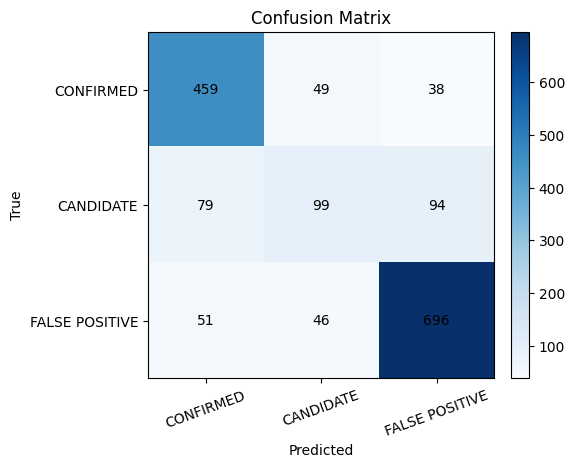

In [9]:
# === Colab Cell 6: Confusion Matrix (matplotlib) ===
cm = confusion_matrix(y_test, y_pred, labels=["CONFIRMED","CANDIDATE","FALSE POSITIVE"])
fig, ax = plt.subplots(figsize=(5.5,4.5))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.set_xticklabels(["CONFIRMED","CANDIDATE","FALSE POSITIVE"], rotation=20)
ax.set_yticklabels(["CONFIRMED","CANDIDATE","FALSE POSITIVE"])
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.show()

In [10]:
# === Colab Cell 7: Feature Importances (matplotlib + table) ===
# Извлекаем важности из RF внутри пайплайна:
rf_in = pipe.named_steps["model"]
# Важности соответствуют NUM_FEATURES после импера
importances = rf_in.feature_importances_
fi = pd.DataFrame({"feature": NUM_FEATURES, "importance": importances}).sort_values("importance", ascending=False)
fi.head(10)

feature  importance
3       koi_prad    0.126159
11       koi_ror    0.125878
2      koi_depth    0.106100
0     koi_period    0.101743
5        koi_teq    0.083877
1   koi_duration    0.081774
4     koi_impact    0.078215
9     koi_kepmag    0.069545
10     koi_count    0.063551
8       koi_smet    0.056712

In [17]:
# === Colab Cell 8: Pretty probabilities for a single example (plotly) ===
CLASS_ORDER = pipe.named_steps["model"].classes_.tolist()  # e.g. ['CANDIDATE','CONFIRMED','FALSE POSITIVE']
def plot_probabilities(prob_vector, title="Prediction Probabilities"):
    fig = go.Figure(go.Bar(
        x=[p*100 for p in prob_vector],
        y=CLASS_ORDER,
        orientation='h',
        text=[f"{p*100:.1f}%" for p in prob_vector],
        textposition='auto'
    ))
    fig.update_layout(title=title, xaxis_title="Probability (%)", yaxis_title="Class")
    fig.show()
# demo on the first test row
probs0 = pipe.predict_proba(X_test.iloc[[0]])[0]
pred0 = pipe.predict(X_test.iloc[[0]])[0]
print("Predicted:", pred0)
plot_probabilities(probs0, title="Example #0 — Probabilities")

Predicted: CONFIRMED


In [12]:
# === Colab Cell 9: Quick tune (small randomized search) ===
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    "model__n_estimators": [300, 400, 600, 800],
    "model__max_depth": [None, 12, 16, 22, 28],
    "model__min_samples_split": [2, 4, 6, 8],
    "model__min_samples_leaf": [1, 2, 3, 4],
    "model__max_features": ["sqrt", "log2", None],
}
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    pipe,
    param_distributions=param_grid,
    n_iter=20,
    scoring="f1_macro",
    n_jobs=-1,
    cv=cv,
    random_state=42,
    verbose=1
)
search.fit(X_train, y_train)
best_pipe = search.best_estimator_
print("Best params:", search.best_params_)
print("CV best f1_macro:", search.best_score_)
# Eval on hold-out test
y_pred_best = best_pipe.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)
f1m_best = f1_score(y_test, y_pred_best, average="macro")
print(f"Test Accuracy (tuned): {acc_best:.4f}")
print(f"Test Macro F1 (tuned): {f1m_best:.4f}")
print(classification_report(y_test, y_pred_best, digits=3))
# Replace global pipe with tuned one if better
if f1m_best >= f1m:
    pipe = best_pipe
    print(">>> Using tuned model.")
else:
    print(">>> Keeping baseline model.")
    # === Show final model accuracy in % (NASA style) ===
acc_percent = acc_best * 100
f1_percent = f1m_best * 100
from IPython.display import HTML, display
display(HTML(f"""
<div style='background:#0b0d12; border:2px solid #1e2a38; border-radius:10px;
             padding:20px; text-align:center; font-family:Orbitron; color:#9ed2ff;'>
  <h2 style='color:#00bfff;'>🚀 Model Evaluation Results</h2>
  <p style='font-size:20px;'>
    ✅ <b>Accuracy:</b> <span style='color:#00ffcc;'>{acc_percent:.2f}%</span><br>
    🧠 <b>Macro F1-score:</b> <span style='color:#ffcc00;'>{f1_percent:.2f}%</span>
  </p>
  <p style='font-size:15px; color:#9ed2ff;'>Model performance based on test dataset after parameter tuning.</p>
</div>
"""))

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Best params: {'model__n_estimators': 800, 'model__min_samples_split': 6, 'model__min_samples_leaf': 4, 'model__max_features': None, 'model__max_depth': 28}
CV best f1_macro: 0.7239805017292845
Test Accuracy (tuned): 0.7747
Test Macro F1 (tuned): 0.7114
                precision    recall  f1-score   support

     CANDIDATE      0.494     0.463     0.478       272
     CONFIRMED      0.790     0.813     0.801       546
FALSE POSITIVE      0.854     0.855     0.854       793

      accuracy                          0.775      1611
     macro avg      0.713     0.710     0.711      1611
  weighted avg      0.772     0.775     0.773      1611

>>> Using tuned model.


In [13]:
# === Colab Cell 10: Save model to Drive ===
joblib.dump(pipe, MODEL_PATH)
print("Model saved to:", MODEL_PATH)

Model saved to: /content/drive/MyDrive/exoplanet_mvp/rf_koi_model.pkl


In [14]:
# === Colab Cell 11: Load model (when you start a new session) ===
pipe = joblib.load(MODEL_PATH)
print("Model loaded from:", MODEL_PATH)

Model loaded from: /content/drive/MyDrive/exoplanet_mvp/rf_koi_model.pkl


In [15]:
# === Colab Cell 12: Predict helpers (CSV & single form) + log to Drive ===
from datetime import datetime
CLASS_ORDER = pipe.named_steps["model"].classes_.tolist()
def _header_flag(path):
    # писать header только если файла ещё нет
    return not os.path.exists(path)
def predict_single(params: dict, log=True):
    """
    params: dict с ключами из NUM_FEATURES (числа)
    return: dict {prediction, prob_<class>...}
    """
    # 1) предсказание
    x = pd.DataFrame([params], columns=NUM_FEATURES)
    proba = pipe.predict_proba(x)[0]
    pred  = pipe.predict(x)[0]
    # 2) результат (ключи с пробелами заменяем на '_', чтобы точно не было конфликтов)
    result = {"prediction": pred}
    for cls, p in zip(CLASS_ORDER, proba):
        result[f"prob_{cls.replace(' ', '_')}"] = float(p)
    # 3) логирование (строка = обычный dict; никаких вложенных dict)
    if log:
        row = {"timestamp": datetime.utcnow().isoformat()}
        row.update(params)
        row.update(result)
        pd.DataFrame([row]).to_csv(
            NEW_OBS_CSV,
            mode='a',
            header=_header_flag(NEW_OBS_CSV),
            index=False
        )
    return result
def predict_csv(csv_path: str, log=True):
    data = pd.read_csv(csv_path)
    # проверяем, что все нужные признаки есть
    missing = [c for c in NUM_FEATURES if c not in data.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    proba = pipe.predict_proba(data[NUM_FEATURES])
    preds = pipe.predict(data[NUM_FEATURES])
    out = data.copy()
    out["prediction"] = preds
    for i, cls in enumerate(CLASS_ORDER):
        out[f"prob_{cls.replace(' ', '_')}"] = proba[:, i]
    out.insert(0, "timestamp", datetime.utcnow().isoformat())
    if log:
        out.to_csv(
            NEW_OBS_CSV,
            mode='a',
            header=_header_flag(NEW_OBS_CSV),
            index=False
        )
    return out

In [16]:
# === NASA Dark Theme Interactive Form ===
from IPython.display import display, HTML
import ipywidgets as widgets
# Inject NASA-style dark theme
display(HTML("""
<style>
body {
  background-color: #0b0d12 !important;
  color: #e0e0e0 !important;
  font-family: 'Orbitron', 'Montserrat', sans-serif;
}
.widget-label {
  color: #9ed2ff !important;
  font-weight: 600;
}
.widget-button {
  border-radius: 10px !important;
}
</style>
<link href="https://fonts.googleapis.com/css2?family=Orbitron:wght@400;600&display=swap" rel="stylesheet">
"""))
# Tooltip explanations for each parameter
tooltips = {
    "koi_period": "Orbital period (days)",
    "koi_duration": "Transit duration (hours)",
    "koi_depth": "Transit depth (ppm)",
    "koi_prad": "Planet radius (Earth radii)",
    "koi_snr": "Signal-to-noise ratio",
    "koi_impact": "Impact parameter (0=center, 1=edge)",
    "koi_teq": "Equilibrium temperature (Kelvin)",
    "koi_steff": "Stellar effective temperature (Kelvin)",
    "koi_slogg": "Stellar surface gravity (log g)",
    "koi_smet": "Stellar metallicity [Fe/H]",
    "koi_kepmag": "Kepler magnitude (brightness)",
    "koi_count": "Number of observed transits",
    "koi_ror": "Radius ratio (Rp/Rs)",
}
import plotly.graph_objects as go
def plot_probabilities(probs, title="Class Probabilities (%)"):
    """
    Creates NASA-dark styled probability chart with small holographic planet icon.
    """
    # Цвета столбцов для трёх классов
    colors = ['#00bfff', '#0affaa', '#ffcc00']
    fig = go.Figure()
    # Добавляем планету-иконку сверху как аннотацию (голограмма)
    fig.add_annotation(
        text="🪐",
        xref="paper", yref="paper",
        x=0.5, y=1.15,
        showarrow=False,
        font=dict(size=38),
        align="center"
    )
    # Добавляем столбцы
    fig.add_trace(go.Bar(
        x=CLASS_ORDER,
        y=[p * 100 for p in probs],
        marker_color=colors,
        text=[f"{p*100:.1f}%" for p in probs],
        textposition='outside',
        hovertemplate='%{x}: %{y:.2f}%<extra></extra>'
    ))
    # NASA-dark оформление
    fig.update_layout(
        title={
            'text': f"<b>{title}</b>",
            'x': 0.5,
            'xanchor': 'center',
            'font': {'color': '#9ed2ff', 'size': 22, 'family': 'Orbitron'}
        },
        plot_bgcolor='#0b0d12',
        paper_bgcolor='#0b0d12',
        font=dict(color='#e0e0e0', family='Montserrat'),
        xaxis=dict(
            title='Classification Type',
            color='#9ed2ff',
            showgrid=False,
            tickfont=dict(size=14)
        ),
        yaxis=dict(
            title='Probability (%)',
            color='#9ed2ff',
            showgrid=True,
            gridcolor='#1e2a38',
            tickfont=dict(size=13)
        ),
        bargap=0.35,
        height=470,
        margin=dict(t=80, b=60, l=80, r=40),
        annotations=[
            dict(
                text="NASA Exoplanet Explorer AI — Confidence Visualization",
                x=0.5, y=-0.18,
                xref="paper", yref="paper",
                showarrow=False,
                font=dict(color="#6fc9ff", size=13, family="Orbitron")
            )
        ]
    )

    fig.show()
# Create float inputs (NASA blue style)
inputs = {}
for feature in NUM_FEATURES:
    tip = tooltips.get(feature, "")
    inputs[feature] = widgets.FloatText(
        value=0.0,
        description=feature,
        tooltip=tip,
        style={'description_width': '150px'},
        layout=widgets.Layout(width="420px")
    )
# Predict button (glowing blue)
run_button = widgets.Button(
    description="🚀 Predict Exoplanet Type",
    button_style="",  # we'll style manually
    layout=widgets.Layout(width="300px", margin="10px 0 10px 0")
)
run_button.style.button_color = '#0a84ff'
run_button.style.font_weight = 'bold'
run_button.style.font_color = '#ffffff'
# Output zone
output = widgets.Output()
def interpret_result(pred_class, confidence):
    if confidence >= 85:
        return "🪐 High probability — likely a true exoplanet."
    elif confidence >= 60:
        return "🌗 Medium probability — further observations recommended."
    else:
        return "⚪️ Low probability — likely a false signal or noise."
def on_click_run(b):
    with output:
        output.clear_output()
        params = {f: w.value for f, w in inputs.items()}
        res = predict_single(params, log=True)
        best_class = res["prediction"]
        prob_key = f"prob_{best_class.replace(' ', '_')}"
        confidence = res[prob_key] * 100
        interpretation = interpret_result(best_class, confidence)
        # print NASA-style results
        display(HTML(f"""
        <div style='padding:15px; background:#10131a; border:1px solid #1e2a38; border-radius:10px;'>
          <h3 style='color:#00bfff;'>🔹 Prediction: <span style="color:#9ed2ff;">{best_class}</span></h3>
          <p style='font-size:16px;'>🧠 Confidence: <b style="color:#00ffcc;">{confidence:.2f}%</b></p>
          <p style='font-size:15px;'>{interpretation}</p>
        </div>
        """))
        # Probability bar chart
        probs = [res[f"prob_{cls.replace(' ', '_')}"] for cls in CLASS_ORDER]
        plot_probabilities(probs, title=f"Prediction Confidence: {confidence:.1f}%")
# Connect handler
run_button.on_click(on_click_run)
# Display full interactive form
display(*inputs.values(), run_button, output)

FloatText(value=0.0, description='koi_period', layout=Layout(width='420px'), style=DescriptionStyle(descriptio…

FloatText(value=0.0, description='koi_duration', layout=Layout(width='420px'), style=DescriptionStyle(descript…

FloatText(value=0.0, description='koi_depth', layout=Layout(width='420px'), style=DescriptionStyle(description…

FloatText(value=0.0, description='koi_prad', layout=Layout(width='420px'), style=DescriptionStyle(description_…

FloatText(value=0.0, description='koi_impact', layout=Layout(width='420px'), style=DescriptionStyle(descriptio…

FloatText(value=0.0, description='koi_teq', layout=Layout(width='420px'), style=DescriptionStyle(description_w…

FloatText(value=0.0, description='koi_steff', layout=Layout(width='420px'), style=DescriptionStyle(description…

FloatText(value=0.0, description='koi_slogg', layout=Layout(width='420px'), style=DescriptionStyle(description…

FloatText(value=0.0, description='koi_smet', layout=Layout(width='420px'), style=DescriptionStyle(description_…

FloatText(value=0.0, description='koi_kepmag', layout=Layout(width='420px'), style=DescriptionStyle(descriptio…

FloatText(value=0.0, description='koi_count', layout=Layout(width='420px'), style=DescriptionStyle(description…

FloatText(value=0.0, description='koi_ror', layout=Layout(width='420px'), style=DescriptionStyle(description_w…

Button(description='🚀 Predict Exoplanet Type', layout=Layout(margin='10px 0 10px 0', width='300px'), style=But…

Output()

In [18]:
!pip install flask pyngrok
from pyngrok import ngrok
import os
from google.colab import drive
drive.mount('/content/drive')  # Уже есть, но на всякий случай

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Ваш существующий код (импорты и загрузка модели) — вставьте из Cells 1–12
import joblib
import pandas as pd
from datetime import datetime
from flask import Flask, request, jsonify
import threading
import time

# Загрузка модели (из вашего Cell 11)
BASE_DIR = "/content/drive/MyDrive/exoplanet_mvp"
MODEL_PATH = os.path.join(BASE_DIR, "rf_koi_model.pkl")
pipe = joblib.load(MODEL_PATH)
print("Model loaded from:", MODEL_PATH)

# Ваш список фичей и классов (из Cell 3 и 8)
NUM_FEATURES = [
    "koi_period", "koi_duration", "koi_depth", "koi_prad", "koi_snr",
    "koi_impact", "koi_teq", "koi_steff", "koi_slogg", "koi_smet",
    "koi_kepmag", "koi_count", "koi_ror"
]
CLASS_ORDER = pipe.named_steps["model"].classes_.tolist()

# Ваша функция predict_single (адаптирована для API, без лога в CSV — опционально)
def predict_single(params: dict):
    x = pd.DataFrame([params], columns=NUM_FEATURES)
    proba = pipe.predict_proba(x)[0]
    pred = pipe.predict(x)[0]
    result = {"prediction": pred}
    for cls, p in zip(CLASS_ORDER, proba):
        result[f"prob_{cls.replace(' ', '_')}"] = float(p)
    return result

Model loaded from: /content/drive/MyDrive/exoplanet_mvp/rf_koi_model.pkl


In [22]:
app = Flask(__name__)

@app.route('/health', methods=['GET'])
def health():
    return jsonify({"status": "OK", "model": "Exoplanet RF loaded"})

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.json
        if not data or 'params' not in data:
            return jsonify({"error": "Missing 'params' in JSON"}), 400
        params = data['params']
        # Проверяем наличие всех фичей
        missing = [f for f in NUM_FEATURES if f not in params]
        if missing:
            return jsonify({"error": f"Missing features: {missing}"}), 400
        result = predict_single(params)
        # Добавляем timestamp
        result['timestamp'] = datetime.utcnow().isoformat()
        return jsonify(result)
    except Exception as e:
        return jsonify({"error": str(e)}), 500

# Глобальная переменная для ngrok URL
public_url = None

In [23]:
!pip install flask-cors  # Если не установлено
from flask_cors import CORS
CORS(app)  # Разрешает запросы с любого сайта

In [29]:
# Функция для запуска Flask в отдельном потоке (с threaded=True для стабильности)
def run_flask():
    app.run(host='0.0.0.0', port=5000, debug=False, threaded=True)

# Запуск Flask в фоне
flask_thread = threading.Thread(target=run_flask)
flask_thread.daemon = True
flask_thread.start()
time.sleep(10)  # Увеличено ожидание запуска

# Очистка всех существующих туннелей (фиксит лимит 5 endpoints на free аккаунте)
ngrok.kill()

# Настройка ngrok (токен уже вставлен)
NGROK_AUTH_TOKEN = "33e1LCWPrHN2YgLUiwuZgkAIFif_7odPQ8jGqBVHq8tmmQ6gK"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Создаём туннель (proto="http" для HTTP, порт 5000)
public_url = ngrok.connect(5000, proto="http")
print(f"Public API URL: {public_url}")
print(f"API ready! Test: curl -X POST {public_url}/predict -H 'Content-Type: application/json' -d '{{\"params\": {{\"koi_period\": 365.0}}}}'")

 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.


Public API URL: NgrokTunnel: "https://unsplayed-rosaria-flavoressly.ngrok-free.dev" -> "http://localhost:5000"
API ready! Test: curl -X POST NgrokTunnel: "https://unsplayed-rosaria-flavoressly.ngrok-free.dev" -> "http://localhost:5000"/predict -H 'Content-Type: application/json' -d '{"params": {"koi_period": 365.0}}'
